In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.__version__

'2.3.2'

## Read the dataset

In [3]:
df = pd.read_csv('course_lead_scoring.csv')
print(df.shape[0])

1462


In [4]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


## Prepare the dataset

- Check if the missing values are presented in the features.
- If there are missing values:
  - For categorical features, replace them with 'NA'
  - For numerical features, replace with with 0.0

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lead_source               1334 non-null   object 
 1   industry                  1328 non-null   object 
 2   number_of_courses_viewed  1462 non-null   int64  
 3   annual_income             1281 non-null   float64
 4   employment_status         1362 non-null   object 
 5   location                  1399 non-null   object 
 6   interaction_count         1462 non-null   int64  
 7   lead_score                1462 non-null   float64
 8   converted                 1462 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 102.9+ KB


In [6]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [7]:
df.columns

Index(['lead_source', 'industry', 'number_of_courses_viewed', 'annual_income',
       'employment_status', 'location', 'interaction_count', 'lead_score',
       'converted'],
      dtype='object')

In [8]:
categorical_vars = list(df.select_dtypes(include=['object', 'category']).columns)
print(f'Categorical Vars: {categorical_vars}\n')
numeric_vars = list(df.select_dtypes(exclude=['object', 'category']).columns)
numeric_vars.remove('converted') # --> target var
print(f'Numeric Vars: {numeric_vars}')

Categorical Vars: ['lead_source', 'industry', 'employment_status', 'location']

Numeric Vars: ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']


In [9]:
df[categorical_vars] = df[categorical_vars].fillna('NA')
df[numeric_vars] = df[numeric_vars].fillna(0)
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

### Split the data
- Split your data in train/val/test sets with 60%/20%/20% distribution.
- Use Scikit-Learn for that (the train_test_split function) and set the seed to 1.
- Make sure that the target value converted is not in your dataframe.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [11]:
df_full_train, df_test = train_test_split(df, test_size=0.20, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
print(df_train.shape[0]/df.shape[0], df_val.shape[0]/df.shape[0], df_test.shape[0]/df.shape[0])

0.5991792065663475 0.20041039671682626 0.20041039671682626


### Question 1: ROC AUC feature importance
ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
Use the training dataset for that
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['balance'])

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- lead_score
- number_of_courses_viewed
- interaction_count
- annual_income

In [15]:
var_auc = {}
for var in numeric_vars:
    fpr, tpr, thresholds = roc_curve(df_train['converted'], df_train[var])
    var_auc[var] = auc(fpr, tpr)

print(var_auc)
# highest AUC is number_of_courses_viewed

{'number_of_courses_viewed': np.float64(0.7635680590007088), 'annual_income': np.float64(0.5519578313253012), 'interaction_count': np.float64(0.738270176293409), 'lead_score': np.float64(0.6144993577250176)}


## Question 2: Training the model
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.32
- 0.52
- 0.72
- 0.92

In [16]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

# transform the dataset
dv = DictVectorizer(sparse=False)
train_dict = df_train[categorical_vars + numeric_vars].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical_vars + numeric_vars].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_train = df_train['converted'].values
y_val = df_val['converted'].values

# train the model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=1)
model.fit(X_train, y_train)
y_val_pred = model.predict_proba(X_val)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, y_val_pred)
auc_val = auc(fpr, tpr)
print(f'Validation set AUC: {round(auc_val, 3)}')

Validation set AUC: 0.817


## Question 3: Precision and Recall
Now let's compute precision and recall for our model.

Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
For each threshold, compute precision and recall
Plot them
At which threshold precision and recall curves intersect?

- 0.145
- 0.345
- 0.545
- 0.745

In [17]:
def calc_metrics(y_val, y_pred, threshold):
    actual_positives = (y_val==1)
    actual_negatives = (y_val==0)
    
    pred_positives = y_pred >=threshold
    pred_negatives = y_pred < threshold

    tp = (actual_positives & pred_positives).sum()
    tn = (actual_negatives & pred_negatives).sum()
    fp = (actual_negatives & pred_positives).sum()
    fn = (actual_positives & pred_negatives).sum()

    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    return threshold, recall, precision


scores = []
thresholds = np.arange(0, 1.01, 0.01)
for t in thresholds:
    threshold, recall, precision = calc_metrics(y_val, y_val_pred, t)
    scores.append((threshold, recall, precision))

df_scores = pd.DataFrame(scores, columns=['threshold', 'recall', 'precision'])
df_scores

/var/folders/st/3fz_jhxs49xb9mjd487zw_s80000gn/T/ipykernel_77581/524363968.py:14: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


,threshold,recall,precision
0,0.00,1.000000,0.583618
1,0.01,1.000000,0.583618
2,0.02,1.000000,0.583618
3,0.03,1.000000,0.583618
4,0.04,1.000000,0.583618
...,...,...,...
96,0.96,0.017544,1.000000
97,0.97,0.005848,1.000000
98,0.98,0.000000,NaN
99,0.99,0.000000,NaN


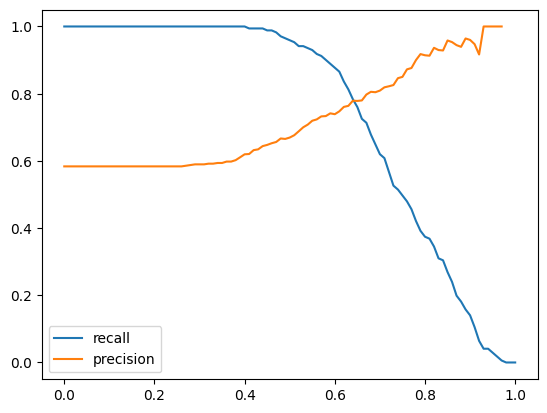

In [18]:
plt.plot(df_scores.threshold, df_scores['recall'], label='recall')
plt.plot(df_scores.threshold, df_scores['precision'], label='precision')
plt.legend()
# intersect closer to 0.7

## Question 4
```Question 4: F1 score
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

F
1
=
2
⋅
P
⋅
R
P
+
R

Where 
P is precision and 
R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01
At which threshold F1 is maximal?

0.14
0.34
0.54
0.74
```

In [19]:
df_scores['f1_score'] = (2 * df_scores['precision'] * df_scores['recall'])/ (df_scores['precision'] + df_scores['recall'])
df_scores

,threshold,recall,precision,f1_score
0,0.00,1.000000,0.583618,0.737069
1,0.01,1.000000,0.583618,0.737069
2,0.02,1.000000,0.583618,0.737069
3,0.03,1.000000,0.583618,0.737069
4,0.04,1.000000,0.583618,0.737069
...,...,...,...,...
96,0.96,0.017544,1.000000,0.034483
97,0.97,0.005848,1.000000,0.011628
98,0.98,0.000000,NaN,NaN
99,0.99,0.000000,NaN,NaN


In [20]:
df_scores['f1_score'].max()

np.float64(0.8124999999999999)

## Question 5
```
Question 5: 5-Fold CV
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)
Iterate over different folds of df_full_train
Split the data into train and validation
Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
Use AUC to evaluate the model on validation
How large is standard deviation of the scores across different folds?

0.0001
0.006
0.06
0.36
```

In [22]:
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

In [24]:
def train(df_train, y_train, C):
    dicts = df_train.to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    return dv, model

def predict(df, dv, model):
    dicts = df.to_dict(orient='records')
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    return y_pred

In [25]:
n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.converted.values
    y_val = df_val.converted.values
    features = categorical_vars + numeric_vars
    dv, model = train(df_train[features], y_train, C=1.0)
    y_pred = predict(df_val[features], dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print(f'Scores: {scores}')
print(f'Mean: {np.mean(scores)}, Std dev: {np.std(scores)}')

Scores: [np.float64(0.8060745924216483), np.float64(0.8713738368910783), np.float64(0.7754320118852139), np.float64(0.8018368617683685), np.float64(0.8558272713202291)]
Mean: 0.8221089148573075, Std dev: 0.03580711942905165


## Question 6
```
Question 6: Hyperparameter Tuning
Now let's use 5-Fold cross-validation to find the best parameter C

Iterate over the following C values: [0.000001, 0.001, 1]
Initialize KFold with the same parameters as previously
Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
Compute the mean score as well as the std (round the mean and std to 3 decimal digits)
Which C leads to the best mean score?

0.000001
0.001
1
If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.
```

In [26]:
n_splits = 5

for C in tqdm([0.000001, 0.001, 1]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/3 [00:00<?, ?it/s]

C=1e-06 0.561 +- 0.024
C=0.001 0.926 +- 0.018
C=1 0.876 +- 0.032


In [ ]:
# C=0.001 leads to best mean score